In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import sheryanalysis as sh 
import warnings
warnings.filterwarnings('ignore')

# Load your dataset
df = pd.read_csv('EB_dataset.csv', encoding='latin1')

In [19]:
# Clean the data 
df = df.drop(columns=['Month_name.1', 'avg_tem', 'Unnamed: 10', 'Unnamed: 11'], errors='ignore')
df['Bill_Amount'] = pd.to_numeric(df['Bill_Amount'].astype(str).str.replace(',', '.'), errors='coerce')
df['Units_Consumed(kwh)'] = pd.to_numeric(df['Units_Consumed(kwh)'], errors='coerce')

In [21]:
valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
df = df[df['Month_name'].isin(valid_months)].reset_index(drop=True)
sh.analyze(df)  

# Map months to numeric and seasons
month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6}
season_map = {'Jan':'Winter', 'Feb':'Winter', 'Mar':'Summer', 'Apr':'Summer', 'May':'Summer', 'Jun':'Monsoon'}
df['Month_numeric'] = df['Month_name'].map(month_map)
df['Season'] = df['Month_name'].map(season_map)


🔍 Basic Analysis Report
------------------------------------------------------------
📏 Shape: (1002, 8)
🧱 Columns: ['ID', 'Month_name', 'Type', 'No. of occupants', 'Units_Consumed(kwh)', 'Bill_Amount', 'Avg_Temp (°C)', 'CDD']

🧼 Columns with nulls: ['No. of occupants', 'Bill_Amount']

🔠 Categorical Columns: ['Month_name', 'Type', 'No. of occupants', 'Avg_Temp (°C)', 'CDD']

🔢 Numerical Columns: ['Units_Consumed(kwh)', 'Bill_Amount']

📝 Text Columns: ['ID']


In [23]:
# Handle missing values in occupants
df['No. of occupants'] = pd.to_numeric(df['No. of occupants'], errors='coerce')

# Split datasets by Type
df_domestic = df[df['Type'] == 'Domestic'].copy()
df_commercial = df[df['Type'] == 'Commercial'].copy()

In [25]:
# Drop NaN occupants for domestic analysis
df_domestic = df_domestic.dropna(subset=['No. of occupants'])

print(f"Data loaded: {len(df_domestic)} domestic, {len(df_commercial)} commercial records")

Data loaded: 738 domestic, 264 commercial records


In [27]:
# === ANALYSIS ===
print("="*60)
print("DOMESTIC vs COMMERCIAL CONSUMPTION: KEY DIFFERENCES")
print("="*60)

# Domestic Analysis - What WORKS
print("\nDOMESTIC CONSUMPTION: PREDICTABLE PATTERNS")
print("Features that ACTUALLY matter for households:")

# Calculate domestic temperature correlation
dom_corr_temp = df_domestic['Units_Consumed(kwh)'].corr(df_domestic['Avg_Temp (°C)'])
dom_corr_occupants = df_domestic['Units_Consumed(kwh)'].corr(df_domestic['No. of occupants'])

print(f"• Temperature correlation: {dom_corr_temp:.3f} (Moderate positive)")
print(f"• Occupancy correlation: {dom_corr_occupants:.3f} (Clear relationship)")

# DOMESTIC ML MODEL WITH FEATURE IMPORTANCE

# Prepare domestic ML data
X_dom = df_domestic[['Avg_Temp (°C)', 'No. of occupants', 'Month_numeric']]
y_dom = df_domestic['Units_Consumed(kwh)']

DOMESTIC vs COMMERCIAL CONSUMPTION: KEY DIFFERENCES

DOMESTIC CONSUMPTION: PREDICTABLE PATTERNS
Features that ACTUALLY matter for households:
• Temperature correlation: 0.211 (Moderate positive)
• Occupancy correlation: 0.502 (Clear relationship)


In [29]:
# ML Model for domestic - WITH FEATURE IMPORTANCE
rf_dom = RandomForestRegressor(n_estimators=100, random_state=42)
rf_dom.fit(X_dom, y_dom)  # Need to fit to get feature importance
rf_dom_cv_scores = cross_val_score(rf_dom, X_dom, y_dom, cv=5, scoring='r2')

print(f"• Domestic ML Model R²: {rf_dom_cv_scores.mean():.3f} ({rf_dom_cv_scores.mean()*100:.1f}% better than random guessing)")

# ADDED: FEATURE IMPORTANCE ANALYSIS
print("\n DOMESTIC FEATURE IMPORTANCE (Random Forest):")
feature_names = ['Temperature', 'Occupants', 'Month']
importance_dom = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_dom.feature_importances_
}).sort_values('Importance', ascending=False)

for _, row in importance_dom.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.3f}")

# Show domestic seasonal patterns clearly
print("\n DOMESTIC SEASONAL PATTERNS (Clear Trend):")
dom_seasonal = df_domestic.groupby('Season')['Units_Consumed(kwh)'].mean()
for season, consumption in dom_seasonal.items():
    print(f"  {season}: {consumption:.1f} kWh")


• Domestic ML Model R²: 0.173 (17.3% better than random guessing)

 DOMESTIC FEATURE IMPORTANCE (Random Forest):
  Occupants: 0.820
  Temperature: 0.091
  Month: 0.089

 DOMESTIC SEASONAL PATTERNS (Clear Trend):
  Monsoon: 182.6 kWh
  Summer: 163.9 kWh
  Winter: 123.2 kWh


In [30]:
# Commercial Analysis - What DOESN'T work
print("\nCOMMERCIAL CONSUMPTION: UNPREDICTABLE")
print("Why commercial patterns are chaotic:")

# Show commercial data variability
com_std = df_commercial['Units_Consumed(kwh)'].std()
com_mean = df_commercial['Units_Consumed(kwh)'].mean()
com_cv = com_std / com_mean  # Coefficient of variation

print(f"• Average consumption: {com_mean:.1f} kWh")
print(f"• Standard deviation: {com_std:.1f} kWh") 
print(f"• Variability (CV): {com_cv:.1f} (Extremely high!)")


COMMERCIAL CONSUMPTION: UNPREDICTABLE
Why commercial patterns are chaotic:
• Average consumption: 1184.5 kWh
• Standard deviation: 3813.6 kWh
• Variability (CV): 3.2 (Extremely high!)


In [43]:
# COMMERCIAL ML MODEL WITH FEATURE IMPORTANCE
# Prepare commercial ML data
X_com = df_commercial[['Avg_Temp (°C)', 'Month_numeric']]
y_com = df_commercial['Units_Consumed(kwh)']

# ML Model for commercial - WITH FEATURE IMPORTANCE
rf_com = RandomForestRegressor(n_estimators=100, random_state=42)
rf_com.fit(X_com, y_com)  # Need to fit to get feature importance
rf_com_cv_scores = cross_val_score(rf_com, X_com, y_com, cv=5, scoring='r2')

print(f"• Commercial ML Model R²: {rf_com_cv_scores.mean():.3f} (Completely unpredictable)")

# ADDED: COMMERCIAL FEATURE IMPORTANCE
print("\n COMMERCIAL FEATURE IMPORTANCE (Random Forest):")
feature_names_com = ['Temperature', 'Month']
importance_com = pd.DataFrame({
    'Feature': feature_names_com,
    'Importance': rf_com.feature_importances_
}).sort_values('Importance', ascending=False)

for _, row in importance_com.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.3f}")



• Commercial ML Model R²: -2.708 (Completely unpredictable)

 COMMERCIAL FEATURE IMPORTANCE (Random Forest):
  Month: 0.512
  Temperature: 0.488


In [45]:
#  ADDED: ML MODEL VALIDATION COMPARISON
print("\n ML MODEL VALIDATION COMPARISON:")
gb_scores = cross_val_score(GradientBoostingRegressor(random_state=42), X_dom, y_dom, cv=5, scoring='r2')
models = {
    'Random Forest': rf_dom_cv_scores.mean(),
    'Gradient Boosting': gb_scores.mean()
}

for model_name, score in models.items():
    print(f"  {model_name}: R² = {score:.3f}")


 ML MODEL VALIDATION COMPARISON:
  Random Forest: R² = 0.173
  Gradient Boosting: R² = 0.172


In [32]:
# Show commercial examples to prove randomness
print("\n COMMERCIAL REAL-WORLD EXAMPLES (Your Data):")
com_examples = df_commercial.groupby('ID')['Units_Consumed(kwh)'].mean().sort_values()
print("Smallest users:")
for i, (user_id, consumption) in enumerate(com_examples.head(3).items()):
    print(f"  {user_id}: {consumption:.1f} kWh")
print("Largest users:")
for i, (user_id, consumption) in enumerate(com_examples.tail(3).items()):
    print(f"  {user_id}: {consumption:.1f} kWh")



 COMMERCIAL REAL-WORLD EXAMPLES (Your Data):
Smallest users:
  C18: 3.8 kWh
  C91: 39.7 kWh
  H148: 46.2 kWh
Largest users:
  C164: 2460.5 kWh
  C02: 3314.8 kWh
  C26: 25405.3 kWh


In [33]:
# Temperature impact comparison
print("\nTEMPERATURE IMPACT COMPARISON:")
print("Domestic: Clear increase with temperature")
temp_groups = df_domestic.groupby(pd.cut(df_domestic['Avg_Temp (°C)'], 3))['Units_Consumed(kwh)'].mean()
for temp_range, consumption in temp_groups.items():
    print(f"  {temp_range}: {consumption:.1f} kWh")

print("Commercial: No clear temperature pattern")  
temp_groups_com = df_commercial.groupby(pd.cut(df_commercial['Avg_Temp (°C)'], 3))['Units_Consumed(kwh)'].mean()
for temp_range, consumption in temp_groups_com.items():
    print(f"  {temp_range}: {consumption:.1f} kWh")


TEMPERATURE IMPACT COMPARISON:
Domestic: Clear increase with temperature
  (24.494, 26.533]: 123.2 kWh
  (26.533, 28.567]: 149.0 kWh
  (28.567, 30.6]: 175.1 kWh
Commercial: No clear temperature pattern
  (24.494, 26.533]: 1140.0 kWh
  (26.533, 28.567]: 1224.4 kWh
  (28.567, 30.6]: 1200.6 kWh


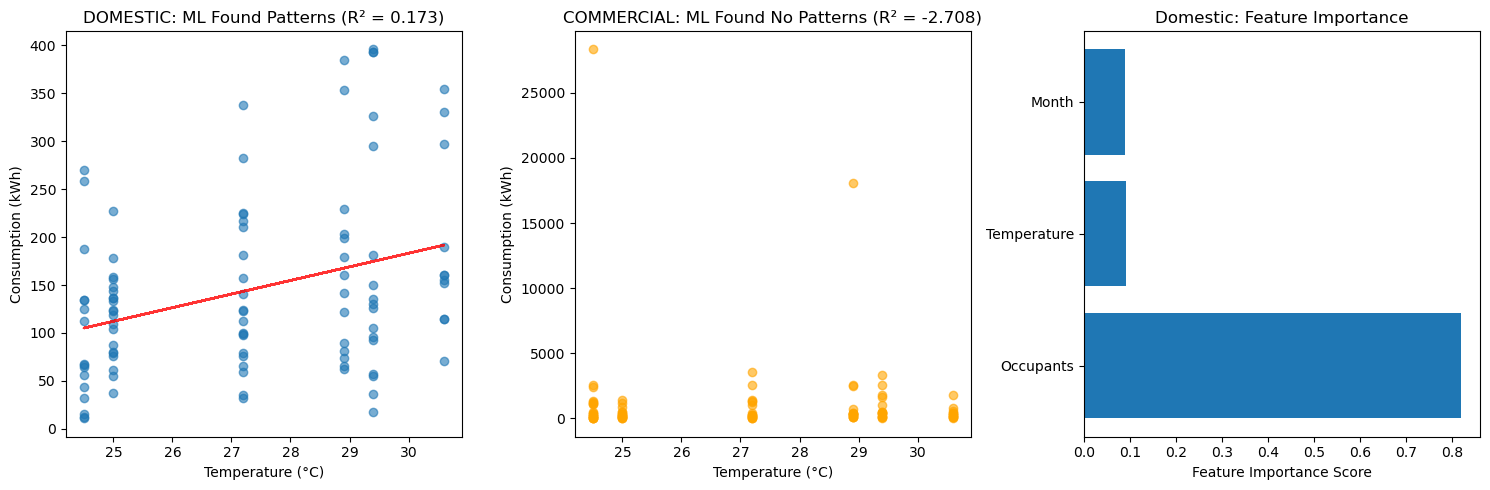

In [34]:
# Create a simple visualization to prove your point
plt.figure(figsize=(15, 5))

# Domestic: Show clear temperature relationship
plt.subplot(1, 3, 1)
dom_sample = df_domestic.sample(100, random_state=42)
plt.scatter(dom_sample['Avg_Temp (°C)'], dom_sample['Units_Consumed(kwh)'], alpha=0.6)
plt.xlabel('Temperature (°C)')
plt.ylabel('Consumption (kWh)')
plt.title('DOMESTIC: ML Found Patterns (R² = 0.173)')
z = np.polyfit(dom_sample['Avg_Temp (°C)'], dom_sample['Units_Consumed(kwh)'], 1)
p = np.poly1d(z)
plt.plot(dom_sample['Avg_Temp (°C)'], p(dom_sample['Avg_Temp (°C)']), "r--", alpha=0.8)

# Commercial: Show randomness  
plt.subplot(1, 3, 2)
com_sample = df_commercial.sample(min(100, len(df_commercial)), random_state=42)
plt.scatter(com_sample['Avg_Temp (°C)'], com_sample['Units_Consumed(kwh)'], alpha=0.6, color='orange')
plt.xlabel('Temperature (°C)')
plt.ylabel('Consumption (kWh)')
plt.title('COMMERCIAL: ML Found No Patterns (R² = -2.708)')

# ADDED: FEATURE IMPORTANCE VISUALIZATION
plt.subplot(1, 3, 3)
plt.barh(importance_dom['Feature'], importance_dom['Importance'])
plt.xlabel('Feature Importance Score')
plt.title('Domestic: Feature Importance')
plt.tight_layout()

plt.tight_layout()
plt.show()